# ⚠️⚠️⚠️⚠️⚠️ ***Attention*** ⚠️⚠️⚠️⚠️⚠️

Please specify your assigned GPU number.

In [ ]:
GPU_NUM = # put GPU number here

# 0. Import essential libraries and evironment setting 

In [1]:
import pandas as pd
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ['CUDA_LAUNCH_BLOCKING'] = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = str(GPU_NUM)
import keras

2024-08-12 16:10:44.176066: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 16:10:44.191515: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 16:10:44.191559: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-12 16:10:44.204366: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-12 16:10:45.256684: W tensorflow/compiler/tf

In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from functools import partial
from concurrent.futures import ProcessPoolExecutor
import itertools
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
from keras.preprocessing import image 
from keras.layers import Rescaling
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import image_dataset_from_directory

# 1. Design your CXR model

## 1.1. Set input size and load pre-trained model
<li>Pre-Trained Model:
A model that has already been trained on a large and general dataset (e.g., ImageNet for image classification, Wikipedia text for NLP tasks).
<li>Advantages of Using a Pre-Trained Model:Reduced Training Time, Better Performance

In [4]:
# Define the input size
input_shape = (224, 224, 3)
# Load ResNet50 model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

2024-08-12 16:10:47.045254: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46606 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:61:00.0, compute capability: 8.6


<img src="files/step1.png" alt="Drawing" style="height: 400px;"/>

## 1.2. Connect pretrained model and your own output 

In [5]:
# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)

<img src="files/step2.png" alt="Drawing" style="height: 400px;"/>

In [6]:
num_classes = 1
output = Dense(num_classes, activation='sigmoid')(x)

<img src="files/step3.png" alt="Drawing" style="height: 400px;"/>

In [7]:
model = Model(inputs=base_model.input, outputs=output)

<img src="files/step4.png" alt="Drawing" style="height: 400px;"/>

## 1.3. Compiling the Model¶
To configure the model for training. It sets up the model with key components needed for the training process, including the optimizer, loss function, and evaluation metrics.

In [8]:
# Define loss

BCE = keras.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.1,
    axis=-1,
    reduction="sum_over_batch_size",
    name="binary_crossentropy",
)

In [9]:
# Compile the model
model.compile(loss=BCE,
              optimizer=Adam(learning_rate=0.00001),
              metrics=['accuracy'])

### 1.3.1. Loss 
💡Just like how teachers grade students, we need to provide the model a function in which to grade its answers. This is called a `loss function`. 

We will use a type of loss function called Cross Entropy which is designed to grade if a model predicted the correct category from a group of categories.
This is the loss function for binary classification problems. 

$$ BCE = -{(y_{target}\log(y_{predict}) + (1 - y_{target})\log(1 - y_{predict}))}$$

$$ L = -\sum_{c=1}^Ny_{c,target}\log(y_{c,predict})$$

<img src="files/crossentropy.png" alt="Drawing" style="height: 300px;"/>
<a href="https://www.desmos.com/calculator/zytm2sf56e">Check this out</a> <br>
❗❗If your problem involves more than two classes, you would need to use 'categorical_crossentropy' instead.

### 1.3.2. Optimizer and learning rate

<li>The optimizer tells the model how to change its internal settings (parameters) to improve its predictions. It does this by trying to make the loss function as small as possible.

💡 Imagine you're trying to find the lowest point in a valley while blindfolded. You can only feel the ground around you to decide which direction to move. The optimizer is like a guide who tells you, "Move a little to the left," or "Step forward," based on the slope of the ground. Following these directions, you gradually make your way to the lowest point in the valley, which is like finding the best model settings to make the most accurate predictions.

⭐ Adam is a widely used optimizer that adapts learning rates for each parameter. It usually works well, especially for complex models or when dealing with noisy gradients. 

<li>The learning rate can be thought of as the size of the steps you take as you follow the guide's instructions. If your learning rate is low, it’s like taking very small steps. This means you move slowly and carefully down the slope of the valley. If your learning rate is high, it’s like taking big, quick steps. You might overshoot the lowest point or miss it entirely, bouncing around instead of settling down.
    

⭐ 0.00001 is a low learning rate. It can help achieve more stable convergence, but it might make training slow. If your model is not learning well, you may want to try a slightly higher learning rate (e.g., 0.0001 or 0.00005) or use learning rate scheduling.

<img src="files/adam.png" alt="Drawing" style="height: 400px;"/>

Ref: https://medium.com/@sedatparlak1953/foundation-of-neural-networks-a68925aa7e2

### 1.3.3. Metrics
How you eveluate your model during training? Accuracy is a straightforward metric for classification tasks.<br> 

❗❗However, if your classes are imbalanced, you might want to add additional metrics such as Precision, Recall, or AUC to better evaluate your model’s performance.

# 2. Ready for model training 
Now that we have prepared training and validation data, and a model, it's time to train our model with our training data, and verify it with its validation data.

"Training a model with data" is often also called "fitting a model to data." Put another way, it highlights that the shape of the model changes over time to more accurately understand the data that it is being given.

## 2.1. Batch size and epochs

In [10]:
batch_size = 16
epochs = 200

<img src="files/batch_epoch.png" alt="Drawing" style="height: 400px;"/>
Ref: https://www.javatpoint.com/epoch-in-machine-learning

### 2.1.1. Batch Size
The batch_size is the number of training samples the model processes before updating its internal parameters (weights). During training, the dataset is typically too large to be processed all at once, so it's divided into smaller batches. The model's weights are updated after each batch, rather than after seeing the entire dataset.

💡Imagine you’re baking cookies, the batch size is like the number of cookies you decide to bake at once.

#### ⭐ Effect:
⬇️ Batch Size
Leads to more frequent updates, which can result in a more stable training process, but it also means more noise in the gradient estimation.
Can generalize better but might take longer to converge.
More suitable for models with limited memory (e.g., on GPUs with less memory). <br/>
⬆️ Batch Size:
Leads to less frequent updates but with a more accurate estimate of the gradient.
Can make training faster but might result in overfitting.
Requires more memory, as more data is processed at once.

### 2.1.2 Epochs
An epoch is one complete pass through the entire training dataset. During training, the model usually goes through multiple epochs to learn from the data. After each epoch, the model has seen all samples in the training dataset once, and its parameters have been updated accordingly.
#### ⭐ Effect:
⬇️  Epochs:
May result in underfitting, where the model hasn't learned enough from the data.
In practice, you may need to experiment with different batch_size and epochs values to find the optimal combination for your specific problem and dataset.<br/>

⬆️ Epochs:
Allows the model to learn more from the data, which can improve accuracy. However, after a certain point, it may lead to overfitting, where the model performs well on training data but poorly on unseen data.

## 2.2. Prepare data

### 2.2.1. Load training and validation datasets

<img src="files/training-data-validation-test.png" alt="Drawing" style="height: 500px;"/>

Ref: https://www.v7labs.com/blog/train-validation-test-set

In [11]:
#TRAIN_FOLDER = '/home/fli40/Data/Datathon24_SummerSchool_CXR/Data2_Preprocessed/train/'
#VAL_FOLDER = '/home/fli40/Data/Datathon24_SummerSchool_CXR/Data2_Preprocessed/validation/'

TRAIN_FOLDER = '/fsx/embed/summer-school-24/Datathon24_SummerSchool_CXR/Data2_Preprocessed/train/'
VAL_FOLDER = '/fsx/embed/summer-school-24/Datathon24_SummerSchool_CXR/Data2_Preprocessed/validation/'

train_ds = image_dataset_from_directory(
    TRAIN_FOLDER,
    image_size=input_shape[:2],
    batch_size=batch_size,
)

val_ds = image_dataset_from_directory(
    VAL_FOLDER,
    image_size=input_shape[:2],
    batch_size=batch_size,
)

Found 1354 files belonging to 2 classes.
Found 451 files belonging to 2 classes.


#### ⭐ Why we need validation data?
Reasons:
<li> Model evaluation during training </li>
<li> Hyperparameter tuning</li>
<li> Model selection/early stop</li>

#### ⭐ Why not just use testing data?

Reasons: Overfitting to Test Data, evaluation is biased!

### 2.2.2. Show a batch of training data 

In [ ]:
for images, labels in train_ds.take(1):
    # Convert to numpy for easier manipulation
    images = images.numpy()
    labels = labels.numpy()
    # Plot the images in the batch
    plt.figure(figsize=(10, 10))
    
    for i in range(min(len(images), 9)):  # Display up to 9 images
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].astype("uint8"))
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    plt.show()

### 2.2.3. Normalization
Rescaling helps normalize the pixel values, bringing them into a range that is easier for neural networks to work with.

In [13]:
# Add rescaling
rescale = Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
val_ds = val_ds.map(lambda x, y: (rescale(x), y))

## 2.3. Keep track of your training process 

In [14]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=20, restore_best_weights=True, verbose=1)

model_checkpoint = ModelCheckpoint(
    filepath='./weights/best_model_Data2.keras', 
    monitor='val_loss', 
    save_best_only=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=10, 
    min_lr=1e-7,
    min_delta=0.0001
)

ModelCheckpoint saves copies of the model at specific moments during training. For example, if the model achieves its lowest error rate (best performance) on a validation set, ModelCheckpoint will save the model at that point.

💡 Imagine you’re writing a long document. As you write, you might hit "save" whenever you make significant progress or reach an important point. This way, if your computer crashes, you don't lose all your work; you can start again from the last saved version. Also, if you make changes later that you don’t like, you can go back to a previous version where the document was better.

<li> filepath: Specifies the file path where the model will be saved.
<li> monitor: Determines which metric to monitor to decide when to save the model.
<li> save_best_only: Controls whether the model is saved only when there is an improvement.

In [15]:
# Create a custom callback to update the plot
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
        
    def on_epoch_end(self, epoch, logs={}):
        # Store metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Clear the output and redraw the plot
        clear_output(wait=True)
        plt.figure(figsize=(12, 4))
        plt.plot(self.metrics['loss'], label='Training Loss')
        if 'val_loss' in self.metrics:
            plt.plot(self.metrics['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

## 2.4 Let's go!

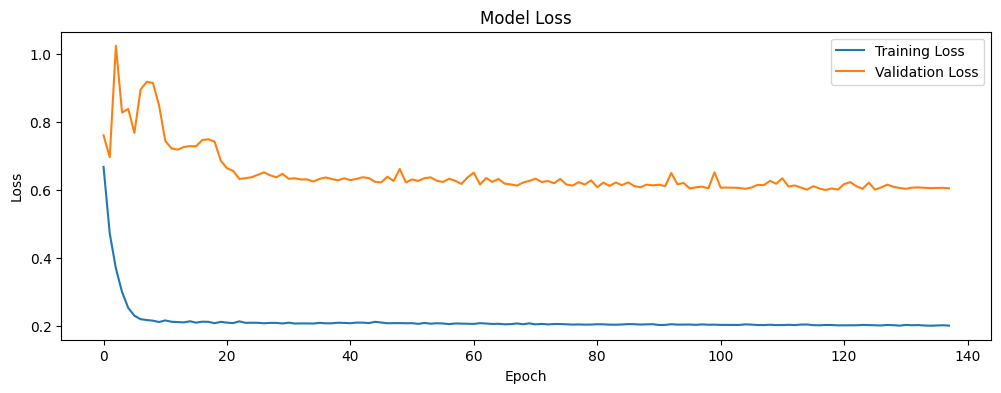

85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 1.0000 - loss: 0.2026 - val_accuracy: 0.7073 - val_loss: 0.6059 - learning_rate: 4.0000e-07
Epoch 138: early stopping
Restoring model weights from the end of the best epoch: 118.


In [16]:
# Train the model
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[PlotLearning(), model_checkpoint, early_stopping, reduce_lr])